# Merging of finantial states with ratings

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pickle
from collections import defaultdict
import sys
from itertools import groupby
import numpy as np
import pandas as pd
from collections import Counter
import gc
from io import StringIO
import datetime

def clear_issuer_name(name):
    name = name.replace(' CORPORATION', '')
    name = name.replace(' CORP', '')
    name = name.replace(' GROUP', '')
    name = name.replace(' INC', '')
    name = name.replace(' CO', '')
    name = name.replace(' S.A.', '')
    name = name.replace(' SA', '')
    name = name.replace(' LP', '')
    name = name.replace(' LTD', '')
    name = name.replace(' LLC', '')
    name = name.replace(' /DE/', '')
    name = name.replace(' /CAN/', '')
    name = name.replace(' LP', '')
    name = name.replace(' /MD/', '')
    name = name.replace(', LP', '')
    name = name.replace(', LP', '')
    name = name.replace(' PLC', '')
    name = name.replace(' LP', '')

    if name.endswith('.'):
        name = name.replace('.', '')

    if name.endswith(','):
        name = name.replace(',', '')

    return name

def get_feats(d, feats):
    return {feat: getattr(d, feat) for feat in feats}

def load_dataset(fin_data_path, rating_path='./datasets/ratings_for_upload.csv'):
    print(fin_data_path, rating_path)

    rating_feats = []
    print('Loading rating data.')
    ratings = pd.read_csv(rating_path)

    rating_feats.append('rating_agency_name')
    rating_feats.append('issuer_name')
    rating_feats.append('rating_type')
    rating_feats.append('rating')
    rating_feats.append('rating_action_date')
    rating_feats.append('file_creating_date')
    rating_feats.append('maturity_date')
    rating_feats.append('sec_category')
    rating_feats.append('issuer_clean')

    print('Loading financial num data.')
    with open(f'./datasets/{fin_data_path}/num.txt') as op:
        df_num = pd.read_csv(StringIO(op.read()),sep='\t')

    print('Loading financial sub data.')
    with open(f'./datasets/{fin_data_path}/sub.txt') as op:
        df_sub = pd.read_csv(StringIO(op.read()),sep='\t')

    adsh_to_name = dict(zip(df_sub.adsh, df_sub.name))

    df_num['issuer_clean'] = df_num['adsh'].apply(adsh_to_name.get).apply(clear_issuer_name)

    del df_sub

    tbt = set(["Standard & Poor's Ratings Services", "Moody's Investors Service", "Fitch Ratings"])
    ratings['issuer_clean'] = ratings['issuer_name'].astype(str).apply(str.upper).apply(clear_issuer_name)
    _ratings = ratings[ratings['issuer_clean'].isin(set(df_num['issuer_clean']))].copy()
    _ratings = _ratings[_ratings['rating_agency_name'].isin(tbt)].copy()
    del ratings
    ratings_per_company = {comp:[] for comp in _ratings['issuer_clean']}

    for row in _ratings.itertuples(index=False):
        ratings_per_company[getattr(row, 'issuer_clean')].append(get_feats(row, rating_feats))

    _sec_num = df_num[df_num['issuer_clean'].isin(set(_ratings['issuer_clean']))].copy()

    del _ratings
    del df_num

    fin_statements = {k: defaultdict(dict) for k in set(_sec_num['issuer_clean'])}

    print('Loading fin statements.')

    for row in _sec_num.itertuples(index=False):
        tag = getattr(row, 'tag')
        qtrs = getattr(row, 'qtrs')
        dt = datetime.datetime.strptime(str(getattr(row, 'ddate')), '%Y%m%d')
        clear_issuer = clear_issuer_name(adsh_to_name[getattr(row, 'adsh')])

        fin_statements[clear_issuer][f'{dt.strftime("%Y_%m")}_{qtrs}Q'][tag] = getattr(row, 'value')

    del _sec_num

    fin_statements_per_year = defaultdict(dict)

    for k in fin_statements:
        for year, group in groupby(sorted(fin_statements[k]), lambda s: s[:4]):
            fin_statements_per_year[k][year] = {}

            for statement in group:
                fin_statements_per_year[k][year].update(fin_statements[k][statement])

    dataset = []

    print('Creating dataset rows.')

    for cmp, ratings in ratings_per_company.items():

        for r in ratings:
            r_year = r['rating_action_date'][0:4]

            if r_year not in fin_statements_per_year[cmp]:
                continue

            row = {}
            row['company'] = cmp
            row['rating'] = r['rating']
            row['rating_type'] = r['rating_type']
            row['rating_agency'] = r['rating_agency_name']
            row['year'] = r_year

            row.update(fin_statements_per_year[cmp][r_year])

            dataset.append(row)

    del ratings_per_company
    del fin_statements
    del fin_statements_per_year

    return dataset

run = False

if run:
    dataset = []
    
    #for year, quarter in ((i,j) for i in ['2015'] for j in ['4']):
    for year, quarter in ((i,j) for i in range(2013,2016) for j in range(1,5)):
        print(len(dataset))
        print(f'{sys.getsizeof(dataset)*0.000001} Mbs\n')
        dataset.extend(load_dataset(f'{year}q{quarter}'))
        print(len(dataset))
        print(f'{sys.getsizeof(dataset)*0.000001} Mbs\n')
    
        gc.collect()
        with open('dataset.pk', 'wb') as handle:
            pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dataset.pk', 'rb') as handle:
    dataset = pickle.load(handle)

datasets_hash = [hash(frozenset(row.items())) for row in dataset]
_, idxs = np.unique(datasets_hash, return_index=True)

np_dataset = np.array(dataset)
unique_dataset = np_dataset[idxs]

columns = []

for row in unique_dataset:
    columns.extend(row.keys())

count_cols = Counter(columns)
most_common = count_cols.most_common(100)
common_cols = [x[0] for x in most_common]

_data = []

for row in unique_dataset:
    _data.append({k:row.get(k, np.nan) for k in common_cols})

df = pd.DataFrame.from_records(_data)
df.to_csv('./datasets/dataset_ready.csv')


# Example of a Decision Tree



In [1]:
!pip install -U scikit-learn
!pip install -U xgboost
!pip install -U matplotlib
!pip install -U graphviz
!pip install -U pandas

     |████████████████████████████████| 26.7 MB 6.8 MB/s eta 0:00:01
ERROR: auto-sklearn 0.14.2 has requirement scikit-learn<0.25.0,>=0.24.0, but you'll have scikit-learn 1.0.2 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 173.6 MB 12 kB/s  eta 0:00:012
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.5.1
    Uninstalling xgboost-1.5.1:
      Successfully uninstalled xgboost-1.5.1
     |████████████████████████████████| 11.3 MB 10.5 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0
     |████████████████████████████████| 46 kB 679 kB/s eta 0:00:01
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.19
    Uninstal

In [1]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier

def test_clf(clf, X_train, X_test, y_train, y_test):
    score = {}
  
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)

    score['test_acc'] = accuracy_score(y_test, y_test_pred)
    score['train_acc'] = accuracy_score(y_train, y_train_pred)
    score['test_f1'] = f1_score(y_test, y_test_pred, average='weighted')

    return score

wine_X, wine_y = load_wine(return_X_y=True)

kwa = {}

kwa['random_state'] = 42
kwa['test_size'] = 0.2

X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y, **kwa)
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_clf(tree, X_train, X_test, y_train, y_test)

{'test_acc': 0.9444444444444444,
 'train_acc': 1.0,
 'test_f1': 0.9439974457215836}

In [2]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import graphviz

plt.figure(figsize=(10,10))

kwa = {}

kwa['decision_tree'] = tree
kwa['out_file'] = None
kwa['feature_names'] = load_wine()['feature_names']
kwa['class_names'] = load_wine()['target_names']
kwa['filled'] = True
kwa['label'] = 'root'
kwa['rounded'] = False
kwa['leaves_parallel'] = False
kwa['impurity'] = False
kwa['special_characters'] = True
kwa['proportion'] = False
kwa['precision'] = 2
kwa['rotate'] = False
kwa['fontname'] = 'times'

dot_data = export_graphviz(**kwa)

graph = graphviz.Source(dot_data)

graph.render(format='pdf', view=True)

'Source.gv.pdf'

<Figure size 720x720 with 0 Axes>

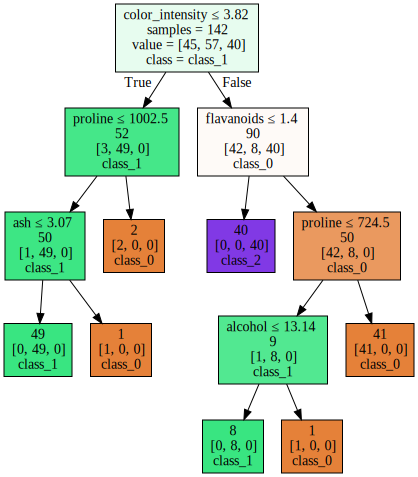

In [3]:
graph

# Modelling of the problem

In [4]:
import pickle
from collections import defaultdict
import sys
from itertools import groupby
import numpy as np
import pandas as pd
from collections import Counter
import gc
from io import StringIO
import datetime

dataset = pd.read_csv('./dataset_ready.csv')

In [5]:
set(dataset['rating'])

{'(P)A2',
 '(P)A3',
 '(P)Aa2',
 '(P)Aa3',
 '(P)B1',
 '(P)B2',
 '(P)B3',
 '(P)Ba1',
 '(P)Ba2',
 '(P)Ba3',
 '(P)Baa1',
 '(P)Baa2',
 '(P)Baa3',
 '(P)C',
 '(P)Ca',
 '(P)Caa1',
 '(P)Caa2',
 '(P)Caa3',
 'A',
 'A (sf)',
 'A+',
 'A+prelim',
 'A-',
 'A- (sf)',
 'A-1',
 'A-1(HIGH)',
 'A-1(LOW)',
 'A-1(MID)',
 'A-1+',
 'A-1+prelim',
 'A-1prelim',
 'A-2',
 'A-3',
 'A-p',
 'A-prelim',
 'A1',
 'A2',
 'A2.ru',
 'A3',
 'A3.ru',
 'AA',
 'AA+',
 'AA+prelim',
 'AA-',
 'AA-prelim',
 'AA/A-1+',
 'AAA',
 'AAAm',
 'AAAprelim',
 'AAprelim',
 'Aa1',
 'Aa2',
 'Aa3',
 'Aaa',
 'Ap',
 'Aprelim',
 'Aprelim (sf)',
 'B',
 'B+',
 'B+prelim',
 'B-',
 'B-prelim',
 'B1',
 'B1-PD',
 'B2',
 'B2-PD',
 'B3',
 'B3-PD',
 'BB',
 'BB+',
 'BB+prelim',
 'BB-',
 'BB-prelim',
 'BBB',
 'BBB+',
 'BBB+(EXP)',
 'BBB+p',
 'BBB+prelim',
 'BBB-',
 'BBB- (sf)',
 'BBB-(EXP)',
 'BBB-prelim',
 'BBB-prelim (sf)',
 'BBBprelim',
 'BBprelim',
 'Ba1',
 'Ba1-PD',
 'Ba2',
 'Ba2-PD',
 'Ba3',
 'Ba3-PD',
 'Ba3.ru',
 'Baa1',
 'Baa2',
 'Baa3',
 'Baa3.ru',

In [6]:
dataset['rating_type'].value_counts()

Instrument                                           28674
Local Currency Preliminary LT                        28468
Local Currency LT                                    12516
Long Term Rating                                      9901
Local Currency ST                                     5036
Organization                                          1774
Short Term Rating                                     1680
Foreign Currency LT                                   1557
Foreign Currency Preliminary LT                       1361
Program                                                695
S&P Published Underlying Rating                        589
Foreign Currency ST                                    422
Canada National Scale Commercial Paper                  85
Local Currency Preliminary ST                           49
Greater China Regional Scale LT                         26
Sale                                                    24
Foreign Currency Principal LT                           

In [7]:
eu_quality_step = {
    'Aaa': "1", # Moody's Investors Service - Long-term
    'Aa1': "1",
    'Aa2': "1",
    'Aa3': "1",
    'A1': "2",
    'A2': "2",
    'A3': "2",
    'Baa1': "3",
    'Baa2': "3",
    'Baa3': "3",
    'Ba1': "4",
    'Ba2': "4",
    'Ba3': "4",
    'B1': "5",
    'B2': "5",
    'B3': "5",
    'Caa1': "6",
    'Caa2': "6",
    'Caa3': "6",
    'Ca': "6",
    'C': "6",
    'P-1': "1", # Moody's Investors Service - Short-term
    'P-2': "1",
    'P-3': "1",
    'Not Prime': "1",
    'AAA': "1", # Fitch Ratings - Long-term
    'AA+': "1",
    'AA': "1",
    'AA-': "1",
    'A+': "2",
    'A': "2",
    'A-': "2",
    'BBB+': "3",
    'BBB': "3",
    'BBB-': "3",
    'BB+': "4",
    'BB': "4",
    'BB-': "4",
    'B+': "5",
    'B': "5",
    'B-': "5",
    'CCC+': "6",
    'CCC': "6",
    'CCC-': "6",
    'CC': "6",
    'C': "6",
    'RD': "6", 
    'D': "6",
    'F1+': "1", # Fitch Ratings - Short-term
    'F1': "1",
    'F2': "2",
    'F3': "3",
    'B': "4",
    'C': "6",
    'D': "6",
    'AAA': "1", # Standard & Poor's Ratings Services - Long-term
    'AA+': "1",
    'AA': "1",
    'AA-': "1",
    'A+/A1': "2",
    'A+': "2",
    'A': "2",
    'A-': "2",
    'BBB+': "3",
    'BBB': "3",
    'BBB-': "3",
    'BB+': "4",
    'BB': "4",
    'BB-': "4",
    'B+': "5",
    'B': "5",
    'B-': "5",
    'CCC+': "6",
    'CCC': "6",
    'CCC-': "6",
    'CC': "6",
    'C': "6",
    'RD': "6", 
    'SD': "6",
    'D': "6",
    'A-1+': "1", # Standard & Poor's Ratings Services - Short-term
    'A-1': "2",
    'A-2': "3",
    'A-3': "3",
    'B': "4",
    'C': "6",
    'D': "6"
}

In [8]:
i_s_mapping = {
    '1': "Investment", # Standard & Poor's Ratings Services - Short-term
    '2': "Investment",
    '3': "Investment",
    '4': "Speculative",
    '5': "Speculative",
    '6': "Speculative"
}

In [9]:
rep = ['-PD', 'm','za','\(P\)', 'preli', 'PD', '\(EXP\)', ' \(sf\)', '.ru']
rep.extend(['\(HIGH\)', '\(LOW\)', '\(MID\)', '\(High\)', 'p'])
rep.extend(['cn', 'p', 'z'])
rating_map = dataset["rating"]

for sub in rep:
  rating_map = rating_map.str.replace(sub, '')

dataset['rating_step'] = rating_map.map(eu_quality_step)
dataset['investment_or_speculative'] = dataset['rating_step'].map(i_s_mapping)

/tmp/ipykernel_8402/617717245.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  rating_map = rating_map.str.replace(sub, '')


In [10]:
dataset['rating_step'].value_counts()

3    27738
4    18288
2    11733
5    10664
6     5726
1     3668
Name: rating_step, dtype: int64

In [11]:
dataset['investment_or_speculative'].value_counts()

Investment     43139
Speculative    34678
Name: investment_or_speculative, dtype: int64

In [12]:
dataset.reset_index()
dataset_clean = dataset.loc[dataset['rating_step'].notna()]
dataset_clean.dropna(axis='index', thresh=50, inplace=True)
dataset_clean.dropna(axis='columns', thresh=int(dataset_clean.shape[0]*.6), inplace=True)
# dataset_clean = dataset_clean.loc[dataset_clean['rating_type']]
drop_cols = ['company', 'rating', 'rating_type', 'Unnamed: 0', 'rating_agency', 'year', 'investment_or_speculative']
drop_cols.append('rating_step')

X = dataset_clean.drop(columns=drop_cols).copy()
y = dataset_clean['rating_step'].copy()

# X.dropna(axis='index', thresh=20, inplace=True)

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [13]:
dataset_clean.shape

(44021, 46)

In [14]:
X.fillna(0, inplace=True)

In [15]:
y.value_counts()

3    16068
4    10636
2     6363
5     6141
6     2994
1     1819
Name: rating_step, dtype: int64

In [16]:
y.value_counts()[0]/len(y)

0.36500761000431614

In [17]:
X.describe()

,CashAndCashEquivalentsAtCarryingValue,IncomeTaxExpenseBenefit,Assets,LiabilitiesAndStockholdersEquity,AccumulatedOtherComprehensiveIncomeLossNetOfTax,CashAndCashEquivalentsPeriodIncreaseDecrease,NetIncomeLoss,StockholdersEquity,ComprehensiveIncomeNetOfTax,RetainedEarningsAccumulatedDeficit,...,LiabilitiesCurrent,DeferredIncomeTaxExpenseBenefit,PaymentsToAcquirePropertyPlantAndEquipment,Liabilities,StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,OtherAssetsNoncurrent,OtherLiabilitiesNoncurrent,ProfitLoss,AccountsPayableCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment
count,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,...,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04,4.402100e+04
mean,3.382247e+09,6.330374e+08,5.678808e+10,8.863828e+10,-7.789281e+08,-5.965086e+07,7.710335e+08,1.357813e+10,1.022642e+09,9.329059e+09,...,4.233550e+09,1.666334e+08,7.422785e+08,5.042509e+10,1.398538e+10,1.037545e+09,6.157037e+08,6.841896e+08,9.050500e+08,5.942362e+09
std,4.745474e+10,9.932743e+09,7.519324e+11,1.226302e+12,2.088962e+10,1.687154e+10,1.456375e+10,1.527490e+11,1.995403e+10,1.025633e+11,...,8.441900e+10,4.829767e+09,1.258682e+10,1.402831e+12,1.655857e+11,3.309853e+10,8.217313e+09,1.390628e+10,1.339082e+10,9.964050e+10
min,-3.714000e+09,-1.154100e+10,-2.235260e+11,-1.437140e+11,-1.646078e+12,-5.498200e+11,-4.566600e+11,-1.084780e+11,-4.945490e+11,-9.167100e+10,...,-4.373580e+10,-5.057300e+10,-2.366000e+09,-7.888100e+10,-1.084780e+11,-2.308311e+10,-6.235000e+09,-3.984250e+11,-6.286835e+09,-7.792000e+09
25%,1.000000e+07,0.000000e+00,1.937000e+09,1.889513e+09,-1.996830e+08,-4.026600e+07,0.000000e+00,1.387610e+08,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.400000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.442100e+08,2.844700e+07,6.272847e+09,6.187100e+09,-1.678000e+07,0.000000e+00,8.084200e+07,1.519800e+09,6.620000e+07,8.080000e+08,...,4.023580e+08,0.000000e+00,1.791300e+07,8.847270e+08,6.574810e+08,3.755100e+07,3.839300e+07,0.000000e+00,3.640000e+07,2.783860e+08
75%,7.080000e+08,1.484630e+08,1.859600e+10,1.905150e+10,6.000000e+03,3.905800e+07,3.994200e+08,5.397000e+09,3.930000e+08,4.004000e+09,...,1.782900e+09,1.372700e+07,1.460000e+08,6.019669e+09,4.733000e+09,2.470000e+08,2.980000e+08,2.499210e+08,3.529000e+08,1.837400e+09
max,2.160335e+12,4.253390e+11,4.396033e+13,4.396033e+13,2.041005e+12,8.449270e+11,8.030480e+11,7.930338e+12,1.726176e+12,5.758641e+12,...,4.783614e+12,3.074210e+11,5.359990e+11,1.819299e+14,8.189844e+12,2.184014e+12,1.454937e+12,8.302330e+11,9.424440e+11,4.885546e+12


In [18]:
print('\\begin{itemize}')
for x in X.columns:
#     print(f'\item {x}')
    print(x)
print('\\end{itemize}')

\begin{itemize}
CashAndCashEquivalentsAtCarryingValue
IncomeTaxExpenseBenefit
Assets
LiabilitiesAndStockholdersEquity
AccumulatedOtherComprehensiveIncomeLossNetOfTax
CashAndCashEquivalentsPeriodIncreaseDecrease
NetIncomeLoss
StockholdersEquity
ComprehensiveIncomeNetOfTax
RetainedEarningsAccumulatedDeficit
WeightedAverageNumberOfDilutedSharesOutstanding
WeightedAverageNumberOfSharesOutstandingBasic
EarningsPerShareBasic
EarningsPerShareDiluted
PropertyPlantAndEquipmentNet
InterestExpense
NetCashProvidedByUsedInInvestingActivities
OperatingIncomeLoss
CommonStockValue
NetCashProvidedByUsedInFinancingActivities
NetCashProvidedByUsedInOperatingActivities
Goodwill
ShareBasedCompensation
CommonStockSharesAuthorized
CommonStockParOrStatedValuePerShare
CommonStockSharesIssued
OtherComprehensiveIncomeLossNetOfTax
AssetsCurrent
LiabilitiesCurrent
DeferredIncomeTaxExpenseBenefit
PaymentsToAcquirePropertyPlantAndEquipment
Liabilities
StockholdersEquityIncludingPortionAttributableToNoncontrollingInt

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


{'test_acc': 0.6299689558567426, 'train_acc': 0.6809242552086714, 'test_f1': 0.6280337365009188}


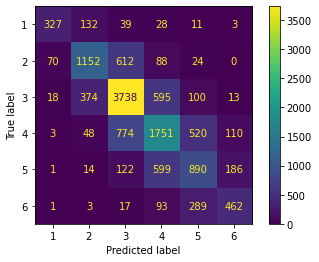

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, **kwa)
tree = DecisionTreeClassifier(max_depth=10)

tree.fit(X_train, y_train)
plot_confusion_matrix(tree, X_test, y_test)
print(test_clf(tree, X_train, X_test, y_train, y_test))

In [30]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
test_clf(xgb, X_train, X_test, y_train, y_test)

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:58:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'test_acc': 0.6890285454683123,
 'train_acc': 0.8060297267475822,
 'test_f1': 0.6870010833603615}

In [40]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
test_clf(rfc, X_train, X_test, y_train, y_test)

{'test_acc': 0.6632846217914742,
 'train_acc': 0.8162523528266372,
 'test_f1': 0.6617790804151963}

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


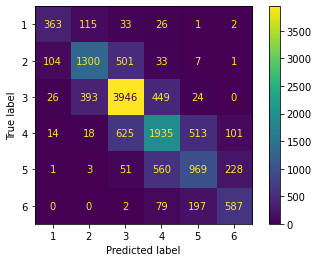

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb, X_test, y_test)

In [41]:
# Seleção de variáveis:
from sklearn.preprocessing import RobustScaler, StandardScaler

# Scoring:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix

# IO libs:
import pickle
from pprint import pprint
import matplotlib.pyplot as plt

_SCORING = ['precision_micro']
_CV_K_FOLDS = 2
_N_OPTIMIZATION_ITERS = 20
r_seed = 42

class SolutionTester():
    def __init__(self, clfs, X, y, name):
        self.clfs = clfs
        self.name = name
        self.X = X
        self.y = y
        self.history = {}
        self.approaches = []
        self.SORT_BY = 'test_acc'
        self.scalers = {}

    def __test_clf(self, clf, X_test, X_train):
        y_test_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
        score = {}

        score['test_acc'] = accuracy_score(self.y_test, y_test_pred)
        score['test_recall'] = recall_score(self.y_test, y_test_pred, average='weighted')
        score['test_f1'] = f1_score(self.y_test, y_test_pred, average='weighted')

        score['train_acc'] = accuracy_score(self.y_train, y_train_pred)
        score['train_recall'] = recall_score(self.y_train, y_train_pred, average='weighted')
        score['train_f1'] = f1_score(self.y_train, y_train_pred, average='weighted')

        return score

    def __gen_approaches(self):
        if len(self.approaches) > 0:
            return
        
        std_scaler = StandardScaler()
        rob_scaler = RobustScaler()

        # Dividindo os dados entre treino e teste
        kwa = {}

        kwa['random_state'] = r_seed
        kwa['test_size'] = 0.30 # 30% para o teste e o resto para treino.

        X_train, X_test, _y_train, _y_test = train_test_split(X, y, **kwa)
        self.y_train, self.y_test = np.ravel(_y_train), np.ravel(_y_test)

        # O fit do scaler é feito apenas com os dados de treino.
        # Se o fit for feito com todos os dados teremos data leakage.
        X_train_scaled = std_scaler.fit_transform(X_train)
        X_test_scaled = std_scaler.transform(X_test)

        X_train_rob = rob_scaler.fit_transform(X_train)
        X_test_rob = rob_scaler.transform(X_test)

        self.scalers['Normalização Std'] = std_scaler
        self.scalers['Normalização Robusta'] = rob_scaler

        self.approaches.append([X_train, X_test, 'Originais'])
        self.approaches.append([X_train_scaled, X_test_scaled, 'Normalização Std'])
        self.approaches.append([X_train_rob, X_test_rob, 'Normalização Rob'])

    def save_progress(self):
        if self.name == 'fin_rating_bin':
            pickle.dump(self, open('./tcc/models/binary/model_trained.pkl', 'wb'))
        else:
            pickle.dump(self, open('./tcc/models/multiple/model_trained.pkl', 'wb'))

    @staticmethod
    def load_progress(name):
        if name == 'fin_rating_bin':
            return pickle.load(open('./tcc/models/binary/model_trained.pkl', 'rb'))
        else:
            return pickle.load(open('./tcc/models/multiple/model_trained.pkl', 'rb'))
        
    def run(self):
        self.__gen_approaches()

        for _X_train, _X_test, a_name in self.approaches:
            for clf, grid_params, clf_id in self.clfs:
                if (clf_id, a_name) in self.history:
                    continue

                hist, kwa = {}, {}

                kwa['estimator'] = clf()
                kwa['param_distributions'] = grid_params
                kwa['cv'] = _CV_K_FOLDS
                kwa['n_jobs'] = _CV_K_FOLDS
                kwa['n_iter'] = _N_OPTIMIZATION_ITERS
                kwa['verbose'] = 1

                print(clf, a_name)
                model_grid = RandomizedSearchCV(**kwa)
                model_grid.fit(_X_train, self.y_train)
                clf = model_grid.best_estimator_

                hist['name'] = (clf_id, a_name)
                hist['score'] = self.__test_clf(clf, _X_test, _X_train)
                hist['clf'] = clf
                hist['params'] = model_grid.best_params_
                hist['X_train'] = _X_train
                hist['X_test'] = _X_test

                self.history[(clf_id, a_name)] = hist
                
                self.save_progress()

    def get_top_clfs(self, reverse=False):
        sort_key = lambda x: x['score'][self.SORT_BY]

        return sorted(self.history.values(), key=sort_key, reverse=reverse)

    def print_n_best_clfs(self, n):
        for clf in self.get_top_clfs()[-n:]:
            print(clf['name'])
            print(clf['score'])
            plot_confusion_matrix(clf['clf'], clf['X_test'], self.y_test)
            plt.show()

    def best_feat_imp_clf(self):
        for hist in self.get_top_clfs(reverse=True):
            if hasattr(hist['clf'], 'feature_importances_'):
                return hist['name']

    def get_imp_feats(self):
        f = []
        hist = self.history[self.best_feat_imp_clf()]

        for i, imp in enumerate(hist['clf'].feature_importances_):
            if imp != 0:
                f.append((imp, self.X.columns[i]))
        
        return sorted(f, key=lambda x: x[0])

    def print_importance_list(self):
        for imp in self.get_imp_feats():
            print(f'{imp[1]}: {imp[0]*100:.2f}%')

    def plot_imp_features(self):
        f = self.get_imp_feats()
        hist = self.history[self.best_feat_imp_clf()]

        plt.title(f'Importância das Características na modelagem {self.name}.')
        plt.barh(range(len(f)), [i[0] for i in f], color='b', align='center')
        plt.yticks(range(len(f)), [i[1] for i in f])
        plt.xlabel('Importância da característica')
        plt.suptitle(f'Acertividade {hist["score"]["test_acc"]*100}%')
        plt.show()


In [42]:
import numpy as np

# Modelagem:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

clfs = []
grid_params_dt = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [3, 5, 8, 10, 15, 20, None],
    'min_samples_split': [5, 10, 15, 20, 30, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'min_samples_leaf': [3, 4, 6, 8, 10, 15, 20, 25, 30, 0.01, 0.02, 0.03, 0.04, 0.05],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 40, 60, None]
}
clfs.append((DecisionTreeClassifier, grid_params_dt, 'Árvore de decisão'))

grid_params_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8, 10, 15, 20, 25, 30, None],
    'min_samples_leaf': [3, 4, 6, 8, 10, 15, 20, 25, 30, 0.01, 0.02, 0.03, 0.04, 0.05],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 40, None],
    'min_samples_split': [5, 10, 15, 20, 30, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
clfs.append((RandomForestClassifier, grid_params_rf, 'Floresta Randômica'))

grid_params_xgb = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300, 600]
}
clfs.append((XGBClassifier, grid_params_xgb, 'Gradient Boosting'))

In [43]:
rating = SolutionTester(clfs, X, y, 'fin_rating_multiple')

rating.run()

<class 'sklearn.tree._classes.DecisionTreeClassifier'> Originais
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Originais
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'xgboost.sklearn.XGBClassifier'> Originais
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[23:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
<class 'sklearn.tree._classes.DecisionTreeClassifier'> Normalização Std
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Normalização Std
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'xgboost.sklearn.XGBClassifier'> Normalização Std
Fitting 2 folds for each of 20 candidates, totalling 40 fits
[21:21:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used w

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[01:26:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
<class 'sklearn.tree._classes.DecisionTreeClassifier'> Normalização Rob
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'sklearn.ensemble._forest.RandomForestClassifier'> Normalização Rob
Fitting 2 folds for each of 20 candidates, totalling 40 fits
<class 'xgboost.sklearn.XGBClassifier'> Normalização Rob
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[03:44:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[00:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:47:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/fuhr/.venvs/ia/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWa

[00:40:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:48:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:49:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:53:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [44]:
_SEP = ';'

def print_all_metrics_csv(modelagem, metrica_para_ordenar):
    header = ['nome', 'abordagem', 'test_f1', 'test_acc', 'test_recall', 'train_f1', 'train_acc', 'train_recall']
    results = []

    for model in modelagem.history.values():
        dic = {}

        dic['nome'] = modelagem.name
        dic['abordagem'] = '-'.join(model['name'])

        dic['test_f1'] = round(model['score']['test_f1'], 3)
        dic['test_acc'] = round(model['score']['test_acc'], 3)
        dic['test_recall'] = round(model['score']['test_recall'], 3)
        dic['train_f1'] = round(model['score']['train_f1'], 3)
        dic['train_acc'] = round(model['score']['train_acc'], 3)
        dic['train_recall'] = round(model['score']['train_recall'], 3)

        results.append(dic)

    print(_SEP.join(header)) # Header do CSV.

    results.sort(key=lambda x: x[metrica_para_ordenar])

    for dic in results:
        print(_SEP.join(str(dic[k]).replace('.', ',') for k in header))

print_all_metrics_csv(rating, 'test_f1')

nome;abordagem;test_f1;test_acc;test_recall;train_f1;train_acc;train_recall
fin_rating_multiple;Árvore de decisão-Normalização Rob;0,448;0,484;0,484;0,455;0,49;0,49
fin_rating_multiple;Árvore de decisão-Originais;0,461;0,481;0,481;0,468;0,488;0,488
fin_rating_multiple;Árvore de decisão-Normalização Std;0,493;0,508;0,508;0,511;0,525;0,525
fin_rating_multiple;Floresta Randômica-Normalização Rob;0,53;0,553;0,553;0,54;0,564;0,564
fin_rating_multiple;Floresta Randômica-Normalização Std;0,582;0,598;0,598;0,603;0,618;0,618
fin_rating_multiple;Floresta Randômica-Originais;0,588;0,603;0,603;0,617;0,632;0,632
fin_rating_multiple;Gradient Boosting-Normalização Std;0,7;0,703;0,703;0,789;0,79;0,79
fin_rating_multiple;Gradient Boosting-Originais;0,701;0,703;0,703;0,787;0,788;0,788
fin_rating_multiple;Gradient Boosting-Normalização Rob;0,701;0,704;0,704;0,783;0,785;0,785


('Floresta Randômica', 'Normalização Std')
{'test_acc': 0.5979404861058529, 'test_recall': 0.5979404861058529, 'test_f1': 0.5818949086554625, 'train_acc': 0.6184851041734276, 'train_recall': 0.6184851041734276, 'train_f1': 0.6031955413084108}


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


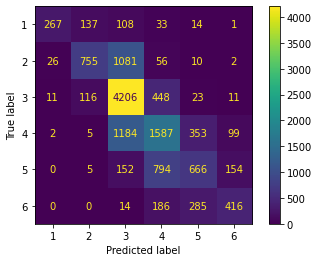

('Floresta Randômica', 'Originais')
{'test_acc': 0.6033164231089574, 'test_recall': 0.6033164231089574, 'test_f1': 0.5877562818131409, 'train_acc': 0.6322450834036477, 'train_recall': 0.6322450834036477, 'train_f1': 0.6172930065789237}


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


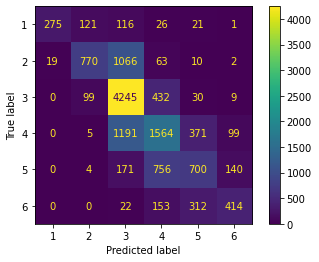

('Gradient Boosting', 'Normalização Std')
{'test_acc': 0.7028091163776785, 'test_recall': 0.7028091163776785, 'test_f1': 0.7001845548806442, 'train_acc': 0.7902252223015512, 'train_recall': 0.7902252223015512, 'train_f1': 0.7889919293928946}


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


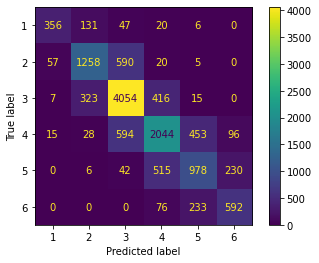

('Gradient Boosting', 'Originais')
{'test_acc': 0.7032634209131521, 'test_recall': 0.7032634209131521, 'test_f1': 0.7008844785201943, 'train_acc': 0.7880184331797235, 'train_recall': 0.7880184331797235, 'train_f1': 0.7868095143614807}


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


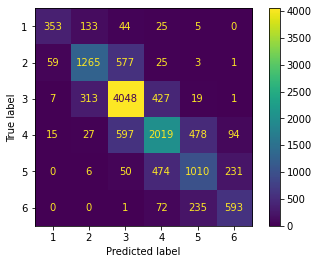

('Gradient Boosting', 'Normalização Rob')
{'test_acc': 0.7037177254486258, 'test_recall': 0.7037177254486258, 'test_f1': 0.7009940721056098, 'train_acc': 0.7846757967157786, 'train_recall': 0.7846757967157786, 'train_f1': 0.7832753800242807}


/home/fuhr/.venvs/ia/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


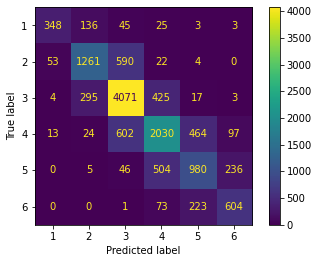

In [45]:
rating.print_n_best_clfs(5)

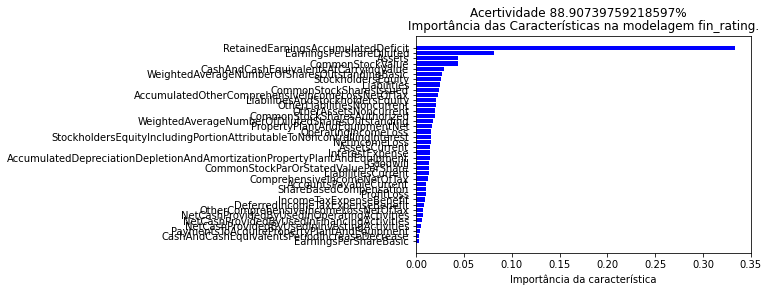

In [479]:
rating.plot_imp_features()

In [443]:
y.value_counts()

3    15520
4    10309
2     6189
5     5953
6     2872
1     1794
Name: rating_step, dtype: int64

In [ ]:
len(y)

In [ ]:
rating = SolutionTester(clfs, X, y, 'fin_rating')

rating.run()

In [ ]:
dataset_clean['rating_step'].value_counts()

In [ ]:

from sklearn.model_selection import train_test_split

kwa = {}

kwa['random_state'] = 43
kwa['test_size'] = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, **kwa)
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
test_clf(xgb, X_train, X_test, y_train, y_test)

In [ ]:
['rating_step'].value_counts()

In [ ]:
dataset_clean.shape